## New / Upgrade
This jupyter notebook creates plots to study the impact of adding new stations vs upgrading existing stations


### 0. Analysis IDs to compare

In [41]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (93, )

### 1. Package Installs

In [42]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [43]:
# Seaborn for plotting
#!pip install seaborn

In [44]:
#!pip install xarray

In [45]:
# Plotly for plotting 
#!pip install plotly

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
import xarray as xr

### 2. Environment Variables

In [47]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [48]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'chargeval_dev'

### 3. Database connection

In [49]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [50]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [51]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [52]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(46727,)

In [53]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

,count,analysis_id
0,904,470
1,897,468
2,898,466
3,897,467
4,904,471
5,904,469
6,897,465


In [54]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

,count,analysis_id
0,896,470
1,891,468
2,891,466
3,891,467
4,896,471
5,896,469
6,890,465


In [55]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

,count,analysis_id
0,7,466
1,8,471
2,6,467
3,8,469
4,8,470
5,6,468
6,7,465


In [56]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, coalesce(ne.count, 0) as nevse_count
from ev_stranded est
         left join (
    select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on est.analysis_id = ne.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY nevse_count;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

,stranded_lat,stranded_lng,analysis_id,nevse_count
0,47.650162,-117.441789,465,0
1,47.525862,-122.703977,465,0
2,47.182122,-121.035108,465,0
3,48.843411,-122.288788,465,0
4,47.519479,-122.729338,465,0


In [57]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

,sum,analysis_id
0,106001.0,470
1,105357.0,468
2,105664.0,466
3,105355.0,467
4,105935.0,471
5,105948.0,469
6,105269.0,465


In [58]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

,count,analysis_id
0,614,470
1,590,468
2,593,466
3,595,467
4,602,471
5,594,469
6,599,465


In [59]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

,count,analysis_id
0,117,470
1,87,468
2,76,466
3,82,467
4,84,471
5,83,469
6,120,465


In [60]:
basecase_aid = 438
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       coalesce(ne.count, 0)               as nevse_count
FROM evse_power_draw epd
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on epd.analysis_id = ne.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s UNION (select %s as analysis_id))
GROUP BY epd.simulation_ts, epd.analysis_id, nevse_count
ORDER BY nevse_count, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,basecase_aid))
evse_util

,analysis_id,datetime,total_power,nevse_count
0,438,2019-07-01 06:00:07,0,0
1,465,2019-07-01 06:00:15,0,0
2,438,2019-07-01 06:01:07,0,0
3,465,2019-07-01 06:01:15,0,0
4,438,2019-07-01 06:02:07,0,0
...,...,...,...,...
8955,466,2019-07-02 01:32:15,0,2
8956,466,2019-07-02 01:33:15,0,2
8957,466,2019-07-02 01:34:15,0,2
8958,466,2019-07-02 01:35:15,0,2


In [61]:
sql_aids = """select analysis_id from analysis_record where set_id IN %s order by analysis_id"""
a_ids = pd.read_sql_query(sql=sql_aids, con=conn, params=(set_id,))['analysis_id'].tolist()
# a_ids = a_ids[:-1]
a_ids

[465, 466, 467, 468, 469, 470, 471]

In [62]:
bevse_df = pd.DataFrame(columns=['latitude', 'longitude', 'bevse_id', 'analysis_id'])
for a_id in a_ids: 
    sql_disabled_bevses = """select be.latitude, be.longitude, be.bevse_id
from built_evse be where dcfc_count > 0 and connector_code IN (1, 2, 3)
    except all
select en.latitude, en.longitude, cast(SUBSTRING(en.evse_id from 2) as double precision) as bevse_id
from evses_now en
where analysis_id = %s"""
    disabled_bevses = pd.read_sql_query(sql=sql_disabled_bevses, con=conn, params=(a_id,))
    disabled_bevses['analysis_id'] = a_id
    # print(disabled_bevses)
    bevse_df = bevse_df.append(disabled_bevses)
    # print(bevse_df)

In [63]:
len(bevse_df)

0

In [64]:
# basecase_aid = 438
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       coalesce(ne.count, 0) as nevse_count,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on ets.analysis_id = ne.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s )
group by ets.analysis_id, nevse_count, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
order by ets.analysis_id
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,))
#count_stats.sort_values(by=['analysis_id'], inplace=True)
count_stats

,sim_count,analysis_id,nevse_count,fin_count,evmt,str_count,cs_count,wait_count
0,897,465,0,890,105269.0,7,599,120
1,898,466,2,891,105664.0,7,593,76
2,897,467,1,891,105355.0,6,595,82
3,897,468,1,891,105357.0,6,590,87
4,904,469,1,896,105948.0,8,594,83
5,904,470,1,896,106001.0,8,614,117
6,904,471,1,896,105935.0,8,602,84


In [65]:
# count_stats.dtypes
# count_stats = count_stats.sort_values(by=['nevse_count'])
# count_stats

In [66]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       coalesce(ne.count, 0) as nevse_count,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on (lai.row_data -> 'analysis_id')::int = ne.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY nevse_count
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,nevse_count,time_taken_tripgen,time_taken_eviabm
0,2021-03-10 03:08:37.876308+00:00,465,2021-03-10 04:36:33.465277+00:00,2021-03-10 08:51:33.949271+00:00,# EV: 897,0,87.0,255.0
1,2021-03-10 03:09:20.765592+00:00,467,2021-03-10 04:45:38.241416+00:00,2021-03-10 08:36:36.141490+00:00,# EV: 897,1,96.0,230.0
2,2021-03-10 20:46:58.068399+00:00,471,2021-03-10 20:59:49.092521+00:00,2021-03-11 00:22:43.804977+00:00,# EV: 904,1,12.0,202.0
3,2021-03-10 20:45:24.936073+00:00,468,2021-03-10 20:58:56.485320+00:00,2021-03-11 00:40:20.873521+00:00,# EV: 897,1,13.0,221.0
4,2021-03-10 20:46:12.968554+00:00,469,2021-03-10 21:00:42.257850+00:00,2021-03-11 00:25:10.635400+00:00,# EV: 904,1,14.0,204.0
5,2021-03-10 20:46:44.554039+00:00,470,2021-03-10 21:00:32.223083+00:00,2021-03-11 00:35:26.488721+00:00,# EV: 904,1,13.0,214.0
6,2021-03-10 03:08:53.610607+00:00,466,2021-03-10 04:40:40.118255+00:00,2021-03-10 08:19:47.400000+00:00,# EV: 898,2,91.0,219.0


### 5. Plotting

#### 5.1 Vehicle Counts

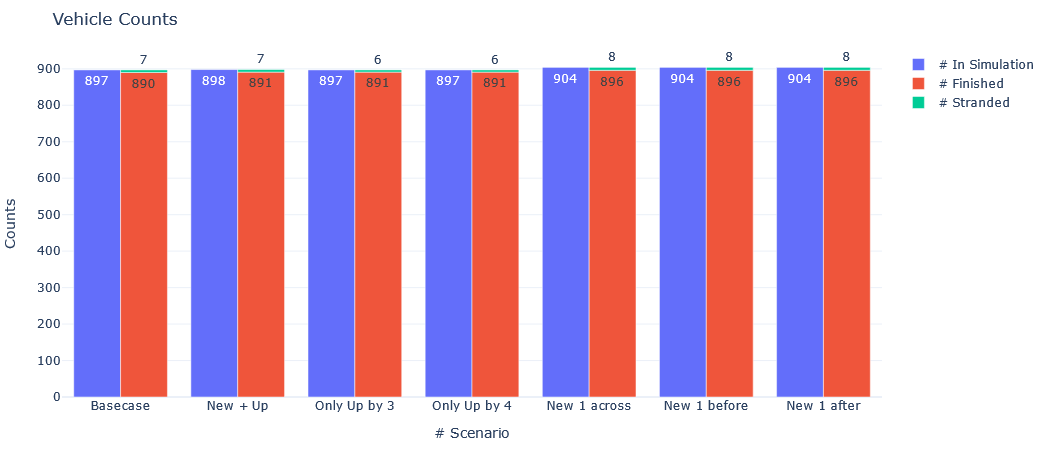

In [68]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# In Simulation",
            x=count_stats['analysis_id'],
            y=count_stats['sim_count'],
            offsetgroup=0,
            text=count_stats['sim_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Finished",
            x=count_stats['analysis_id'],
            y=count_stats['fin_count'],
            offsetgroup=1,
            text=count_stats['fin_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Stranded",
            x=count_stats['analysis_id'],
            y=count_stats['str_count'],
            offsetgroup=1,
            base=count_stats['fin_count'],
            text=count_stats['str_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Vehicle Counts",
        yaxis_title="Counts", 
        xaxis_title="# Scenario", width=600, height=450
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3, 4, 5, 6], ticktext=['Basecase', 'New + Up', 'Only Up by 3', 'Only Up by 4', 'New 1 across', 'New 1 before', 'New 1 after'])
# fig.update_yaxes(range=(0, 1300))
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

## 5.2 eVMT

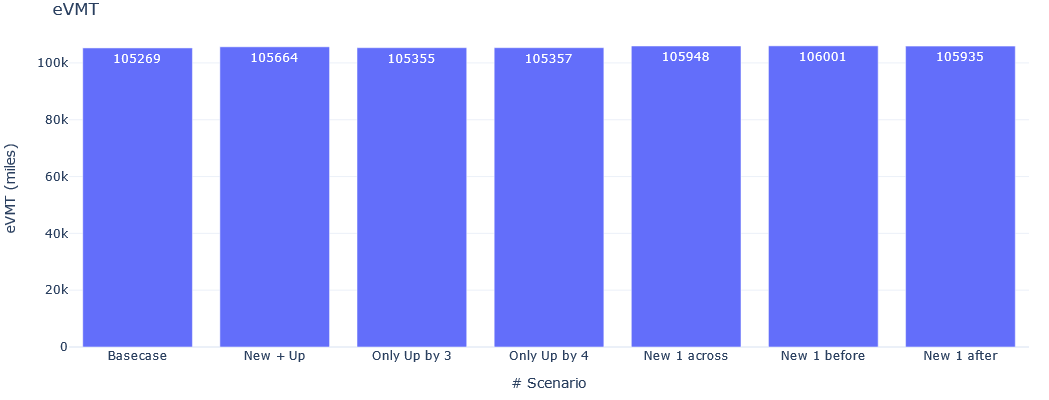

In [69]:
fig = go.Figure(
    data=[
        go.Bar(
            name="eVMT",
            x=count_stats['analysis_id'],
            y=count_stats['evmt'],
            offsetgroup=1,
            text=count_stats['evmt'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="eVMT",
        yaxis_title="eVMT (miles)", 
        xaxis_title="# Scenario", uniformtext_minsize=8, uniformtext_mode='hide', width=400, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3, 4, 5, 6], ticktext=['Basecase', 'New + Up', 'Only Up by 3', 'Only Up by 4', 'New 1 across', 'New 1 before', 'New 1 after'])
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.3 Charging and Waiting Sessions

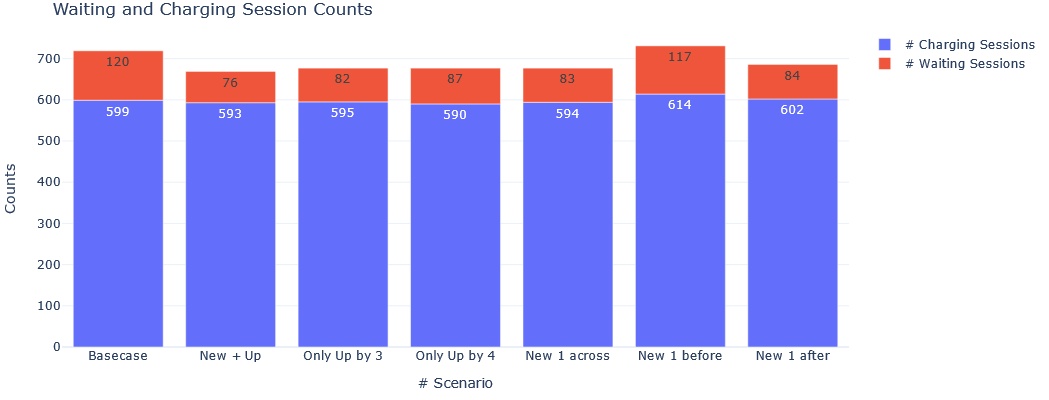

In [70]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# Charging Sessions",
            x=count_stats['analysis_id'],
            y=count_stats['cs_count'],
            offsetgroup=1,
            text=count_stats['cs_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Waiting Sessions",
            x=count_stats['analysis_id'],
            y=count_stats['wait_count'],
            offsetgroup=1,
            base=count_stats['cs_count'],
            text=count_stats['wait_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Waiting and Charging Session Counts",
        yaxis_title="Counts", 
        xaxis_title="# Scenario", width=600, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3, 4, 5, 6], ticktext=['Basecase', 'New + Up', 'Only Up by 3', 'Only Up by 4', 'New 1 across', 'New 1 before', 'New 1 after'])
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.4 EVSE Utilization

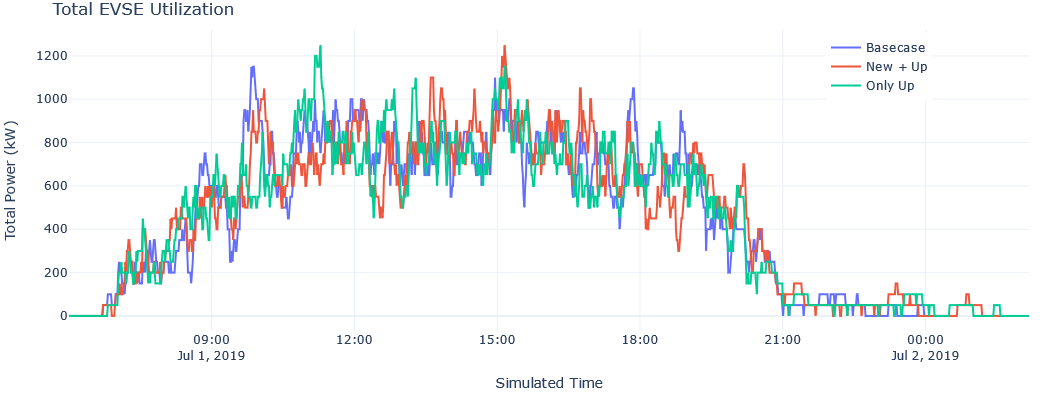

In [38]:
#fig = px.line(evse_util, x="datetime", y="total_power", color='analysis_id', name=['Basecase', 'Scenario - 1', 'Scenario - 2', 'Scenario - 3'], range_x=['2019-07-01 06:00','2019-07-02'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 465]['datetime'], y=evse_util[evse_util['analysis_id'] == 465]['total_power'],
                    mode='lines',
                    name='Basecase'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 466]['datetime'], y=evse_util[evse_util['analysis_id'] == 466]['total_power'],
                    mode='lines',
                    name='New + Up'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 467]['datetime'], y=evse_util[evse_util['analysis_id'] == 467]['total_power'],
                    mode='lines',
                    name='Only Up'))


fig.update_layout(title="Total EVSE Utilization",
                  yaxis_title="Total Power (kW)", 
                  xaxis_title="Simulated Time", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=1000, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20), template='plotly_white', showlegend=True, legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.9
))
fig.show()

In [39]:
token = os.getenv("MAPBOX_ACCESS_TOKEN")
# analysis_ids = new_evses['analysis_id'].unique()

In [40]:
len(bevse_df['analysis_id'].unique())

0

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [192]:
#!jupyter labextension list

In [193]:
#!jupyter labextension uninstall jupyterlab-plotly

In [194]:
#!jupyter labextension uninstall plotlywidget

In [195]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [196]:
#!pip show plotly

In [197]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [198]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [199]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [200]:
#!pip install "nbconvert<6"